# 課題5. 自然言語処理②

### 環境構築

In [1]:
!pip install transformers
!pip install fugashi
!pip install unidic_lite
!pip install seaborn-analyzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 77.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 68.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.3/613.3 KB 43.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 22.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for unidic_lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658834 sha256=6b23613758a1d770d320d42f70dfd1e33691a211d5118b85e152d2d26f807208
  Stored in directory: /root/.cache/pip/wheels/56/9c/4f/2c115e896b4b6c584039ca19de3581d333856782ef

### 課題１

In [3]:
import json
import requests
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr, spearmanr
from transformers import AutoTokenizer, AutoModel
import torch

# BERTモデルの読み込み
tokenizer = AutoTokenizer.from_pretrained("cl-tohoku/bert-base-japanese-v2")
model = AutoModel.from_pretrained("cl-tohoku/bert-base-japanese-v2")

# データセットのダウンロード
url = "https://raw.githubusercontent.com/yahoojapan/JGLUE/main/datasets/jsts-v1.1/valid-v1.1.json"
response = requests.get(url)
data = [json.loads(line) for line in response.text.splitlines()] #JSON Lines形式なので1行ごとにリストの要素としてJSONを保持し，それを各自loadする

# Cosine類似度計算関数
def calculate_cosine_similarity(sent1, sent2):
    tokens1 = tokenizer(sent1, return_tensors="pt")
    tokens2 = tokenizer(sent2, return_tensors="pt")

    with torch.no_grad():
        embeddings1 = model(**tokens1).last_hidden_state.mean(dim=1)
        embeddings2 = model(**tokens2).last_hidden_state.mean(dim=1)

    embeddings1 = torch.squeeze(embeddings1)
    embeddings2 = torch.squeeze(embeddings2)

    cosine_similarity = 1 - cosine(embeddings1, embeddings2)
    return cosine_similarity * 5 #[1,5]にスケーリング

# STSタスクの実行と結果の保存
scores = []
gold_scores = []

for item in data:
    sent1 = item["sentence1"]
    sent2 = item["sentence2"]
    similarity = calculate_cosine_similarity(sent1, sent2)
    scores.append(similarity)
    gold_scores.append(item["label"])

pearson_corr = pearsonr(scores, gold_scores)[0] #PearsonRResult(statistic=0.725241412512534, pvalue=4.0273494288818095e-238). scoreが0, p-valueが１番目の[0,2]リストの形になっているため．
spearman_corr = spearmanr(scores, gold_scores)[0]

with open("results_no1.jsonl", "w") as f:
    f.write(json.dumps({"metrics": "Pearson correlation", "score": pearson_corr}) + "\n")
    f.write(json.dumps({"metrics": "Spearman correlation", "score": spearman_corr}) + "\n")

print("評価結果:")
print(f"Pearson correlation: {pearson_corr}")
print(f"Spearman correlation: {spearman_corr}")


Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v2 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


評価結果:
Pearson correlation: 0.7252414151720105
Spearman correlation: 0.7066443476709469


### 課題2

In [10]:
import json
import requests
from scipy.stats import pearsonr, spearmanr
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

# BERTモデルの読み込み
tokenizer = AutoTokenizer.from_pretrained("cl-tohoku/bert-base-japanese-v2")

class STSDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        inputs = tokenizer(item["sentence1"], item["sentence2"], return_tensors="pt", max_length=512, padding="max_length", truncation=True)
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs["labels"] = torch.tensor(item["label"], dtype=torch.float)
        return inputs

# データセットのダウンロード
def download_dataset(url):
    response = requests.get(url)
    return [json.loads(line) for line in response.text.splitlines()]

train_valid_data = download_dataset("https://raw.githubusercontent.com/yahoojapan/JGLUE/main/datasets/jsts-v1.1/train-v1.1.json")
test_data = download_dataset("https://raw.githubusercontent.com/yahoojapan/JGLUE/main/datasets/jsts-v1.1/valid-v1.1.json") #テストデータとして使うので変数名に注意．


train_data, valid_data = train_test_split(train_valid_data, test_size=0.3) #ホールドアウト法．

train_dataset = STSDataset(train_data)
valid_dataset = STSDataset(valid_data)
test_dataset = STSDataset(test_data)

# 学習の設定
model = AutoModelForSequenceClassification.from_pretrained("cl-tohoku/bert-base-japanese-v2", num_labels=1)

training_args = TrainingArguments(
    output_dir="output",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=1,
    evaluation_strategy="epoch",
    save_strategy="no",
    logging_dir="logs",
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_steps=0,
    fp16=False
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    pearson_corr = pearsonr(predictions.flatten(), labels)[0]
    spearman_corr = spearmanr(predictions.flatten(), labels)[0]
    return {"pearson": pearson_corr, "spearman": spearman_corr}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# モデルの訓練
trainer.train()

# モデルの保存
trainer.save_state()
trainer.save_model()

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v2 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification wer

Epoch,Training Loss,Validation Loss,Pearson,Spearman
1,0.569400,0.477269,0.877603,0.837926
2,0.339900,0.416203,0.893810,0.856156
3,0.208400,0.405827,0.895137,0.858284


In [9]:
# 評価結果の保存
test_results = trainer.predict(test_dataset)
# print(test_results)

with open("results_no2.jsonl", "w") as f:
    f.write(json.dumps({"metrics": "Pearson correlation", "score": test_results.metrics["test_pearson"]}) + "\n")
    f.write(json.dumps({"metrics": "Spearman correlation", "score": test_results.metrics["test_spearman"]}) + "\n")


PredictionOutput(predictions=array([[0.6719649],
       [2.9789588],
       [3.5703902],
       ...,
       [3.3112836],
       [2.4722335],
       [3.9281301]], dtype=float32), label_ids=array([0. , 2.4, 3.6, ..., 2.6, 2.8, 4.2], dtype=float32), metrics={'test_loss': 0.40082210302352905, 'test_pearson': 0.8946544003126126, 'test_spearman': 0.8504891433302013, 'test_runtime': 12.3427, 'test_samples_per_second': 118.045, 'test_steps_per_second': 14.827})


### 課題3

In [33]:
!pip freeze > requirements.txt

In [40]:
threshold = 0.0
unpredicted_sentences = []

preds = [e[0] for e in test_results.predictions]
labels = list(test_results.label_ids)

for i in range(len(preds)):
  if abs(preds[i] - labels[i]) > threshold:
    unpredicted_sentences.append([abs(preds[i] - labels[i]), preds[i] - labels[i] > 0, {'sentence1':test_data[i]["sentence1"], 'sentence2':test_data[i]["sentence2"]}])
    # print(test_data[i]["sentence1"] + "   " + test_data[i]["sentence2"])


unpredicted_sentences.sort(reverse=True)
unpredicted_sentences

[[3.5497367,
  False,
  {'sentence1': '建物の中で一頭の牛が人に引かれて立っています。',
   'sentence2': '会場内で男性がホルスタインを連れています'}],
 [2.7017431,
  False,
  {'sentence1': '足元にキャメル色のカバンがあります。', 'sentence2': '絨毯の上に茶色い旅行トランクが置かれています。'}],
 [2.354354,
  False,
  {'sentence1': 'きりんが草むらの中を歩いています。', 'sentence2': '草原でキリンが歩いているところです。'}],
 [2.1556244,
  True,
  {'sentence1': 'ベットの上には大きなぬいぐるみが置いてあります。',
   'sentence2': '窓のさんにぬいぐるみがかかっている。'}],
 [2.1507678,
  True,
  {'sentence1': '芝生の上に駐車しているバスの近くにきぐるみを着た人が立っています。',
   'sentence2': '芝生の上に赤と緑色に塗り分けられたバスが止まっています。'}],
 [2.1427736,
  True,
  {'sentence1': '赤ちゃんが白いタオルの上に寝ています。',
   'sentence2': '男の子がネクタイを締めて芝生の上に寝ています。'}],
 [2.097839,
  True,
  {'sentence1': 'スマートフォンの上に猫の置物があります。', 'sentence2': '携帯電話が布の上に置かれています。'}],
 [2.0797324,
  False,
  {'sentence1': '赤い車の後ろに、犬が２匹います。', 'sentence2': '車の後ろで２匹のワンコが遊んでいます。'}],
 [2.0286021,
  False,
  {'sentence1': '台所はきれいに片づけられています。', 'sentence2': 'キッチンは生理整頓されており、きれいな状態です。'}],
 [2.0243204,
  False,
  {'sentence1': '小さな鏡が立てかけられ歯ブラシやらとにっくなどが乱雑に並ん

In [41]:
diff_scores = []
for e in unpredicted_sentences:
  print(e[2], e[1])
  diff_scores.append(e[0])

{'sentence1': '建物の中で一頭の牛が人に引かれて立っています。', 'sentence2': '会場内で男性がホルスタインを連れています'} False
{'sentence1': '足元にキャメル色のカバンがあります。', 'sentence2': '絨毯の上に茶色い旅行トランクが置かれています。'} False
{'sentence1': 'きりんが草むらの中を歩いています。', 'sentence2': '草原でキリンが歩いているところです。'} False
{'sentence1': 'ベットの上には大きなぬいぐるみが置いてあります。', 'sentence2': '窓のさんにぬいぐるみがかかっている。'} True
{'sentence1': '芝生の上に駐車しているバスの近くにきぐるみを着た人が立っています。', 'sentence2': '芝生の上に赤と緑色に塗り分けられたバスが止まっています。'} True
{'sentence1': '赤ちゃんが白いタオルの上に寝ています。', 'sentence2': '男の子がネクタイを締めて芝生の上に寝ています。'} True
{'sentence1': 'スマートフォンの上に猫の置物があります。', 'sentence2': '携帯電話が布の上に置かれています。'} True
{'sentence1': '赤い車の後ろに、犬が２匹います。', 'sentence2': '車の後ろで２匹のワンコが遊んでいます。'} False
{'sentence1': '台所はきれいに片づけられています。', 'sentence2': 'キッチンは生理整頓されており、きれいな状態です。'} False
{'sentence1': '小さな鏡が立てかけられ歯ブラシやらとにっくなどが乱雑に並んでいます。', 'sentence2': '洗面台の上に様々な物が並べられています。'} False
{'sentence1': '建物の横に点灯していない信号機があります。', 'sentence2': '電気の点いていない信号機が立っています。'} False
{'sentence1': '庭先にシマウマが２頭立っています。', 'sentence2': 'チェアの近くに２頭のシマウマがいます。'} True
{'sen

<ipython-input-42-3bbc9c787db6>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(diff_scores, kde=False)


<Axes: >

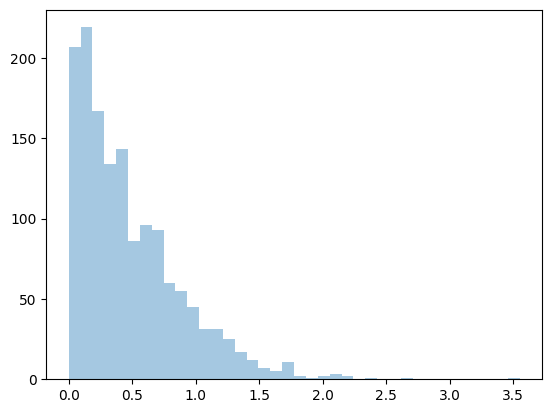

In [42]:
import seaborn as sns

sns.distplot(diff_scores, kde=False)
